# Import

In [1]:
import pandas as pd
import numpy as np
import os
from datetime import datetime as dt
from scipy.stats import mode
import matplotlib.pyplot as plt
import plotly.express as px
from sklearn.model_selection import GridSearchCV
from xgboost import XGBClassifier
import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Input, LSTM, Dense, Dropout
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay, accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, roc_curve
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
import optuna
from optuna.samplers import TPESampler

2025-12-03 14:43:48.512642: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1764773028.666436      19 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1764773028.712173      19 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

# About Dataset
- Sample Rate = 25Hz
- Duration = 20 mins
- AF = 19 respondent
- Non-AF = 16 respondent
- n_data per pasien = 25Hz * (20m * 60s) = 30000 data per pasien
- Total data = 30000 * 35 pasien = 1050000. Tapi detik ke-0 juga diitung jadi = 1050035

In [ ]:
# df = pd.read_csv(r'/kaggle/input/mimic-perform-iii-af-and-non-af-dataset/ppg_af_dataset.csv')
current_dir = os.getcwd()
project_root = os.path.abspath(os.path.join(current_dir, '..', '..'))
file_path = os.path.join(project_root, 'Data', 'ppg_af_dataset.csv')

print(f"file dari: {file_path}")

df = pd.read_csv(file_path)
df

,time,ppg,ecg,resp,status
0,0.000,0.410557,0.314453,0.717097,0
1,0.008,0.400782,0.285156,0.720787,0
2,0.016,0.391007,0.300781,0.723247,0
3,0.024,0.382209,0.304688,0.726937,0
4,0.032,0.372434,0.294922,0.730627,0
...,...,...,...,...,...
5250030,1199.968,0.472141,-0.189453,0.331378,1
5250031,1199.976,0.473118,-0.498047,0.334311,1
5250032,1199.984,0.474096,-0.498047,0.337243,1
5250033,1199.992,0.474096,-0.359375,0.340176,1


# EDA

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5250035 entries, 0 to 5250034
Data columns (total 5 columns):
 #   Column  Dtype  
---  ------  -----  
 0   time    float64
 1   ppg     float64
 2   ecg     float64
 3   resp    float64
 4   status  int64  
dtypes: float64(4), int64(1)
memory usage: 200.3 MB


In [4]:
df.describe()

,time,ppg,ecg,resp,status
count,5.250035e+06,5.247136e+06,5.249660e+06,3.900026e+06,5.250035e+06
mean,6.000000e+02,9.497512e-01,4.150870e-01,2.368876e-01,5.428571e-01
std,3.464125e+02,7.359953e-01,2.779199e-01,4.592674e-01,4.981599e-01
min,0.000000e+00,0.000000e+00,-5.019608e-01,-1.846506e+00,0.000000e+00
25%,3.000000e+02,4.078431e-01,2.649071e-01,2.015883e-02,0.000000e+00
50%,6.000000e+02,5.503421e-01,4.257812e-01,2.355816e-01,1.000000e+00
75%,9.000000e+02,1.678397e+00,5.551758e-01,4.686347e-01,1.000000e+00
max,1.200000e+03,4.001955e+00,1.503937e+00,2.844215e+00,1.000000e+00


In [5]:
status_count = df['status'].value_counts()
status_count

status
1    2850019
0    2400016
Name: count, dtype: int64

## Pie chart AF Status

In [6]:
# Pie chart (for percentage)
status = status_count.sort_index()
status_index = status.index
fig = px.pie(names=status_index, values=status, hole=0.3,
             labels={'names':'status'}, title='AF Status Distribution Pie Chart')
fig.update_traces(textposition='inside', textinfo='percent+label+value')
fig.show()


In [7]:
# df125.isna().sum()
df.isna().sum()

time            0
ppg          2899
ecg           375
resp      1350009
status          0
dtype: int64

In [8]:
# df125.isna().mean() * 100
df.isna().mean() * 100

time       0.000000
ppg        0.055219
ecg        0.007143
resp      25.714286
status     0.000000
dtype: float64

## Visualize signal on specific range

In [9]:
def show_wave_from(df, pasien_ke=1, s_start=0, s_stop=10, fitur='ppg', af_status=0, sample_rate=125):
    lama_ukur = 1200 # 20m = 1200s
    sample_per_pasien = lama_ukur * sample_rate
    duration = s_stop - s_start

    if 0 <= s_start <= lama_ukur and 0 <= s_stop <= lama_ukur:
        if af_status == 0 and 1 <= pasien_ke <= 16:
            afdf = df[df['status'] == 0]
        elif af_status == 1 and 1 <= pasien_ke <= 19:
            afdf = df[df['status'] == 1]
        else:
            print('Invalid nomor pasien atau sample time')

        dfpasien = afdf[(pasien_ke - 1) * sample_per_pasien : pasien_ke * sample_per_pasien]
        dfintvl = dfpasien[sample_rate*s_start : (sample_rate*s_stop)+1]
            
        x_ax = dfintvl['time']
        y_ax = dfintvl[fitur]

        plt.figure(figsize=(16, 4))
        plt.plot(x_ax, y_ax)
        plt.title(f'Gelombang {fitur} dari pasien ke-{pasien_ke} dari {s_start} - {s_stop} detik')

        step = s_start
        for t in range(duration):
            step += 1
            plt.axvline(x=step, color='gray', linestyle='--', linewidth=0.8)

        plt.show()

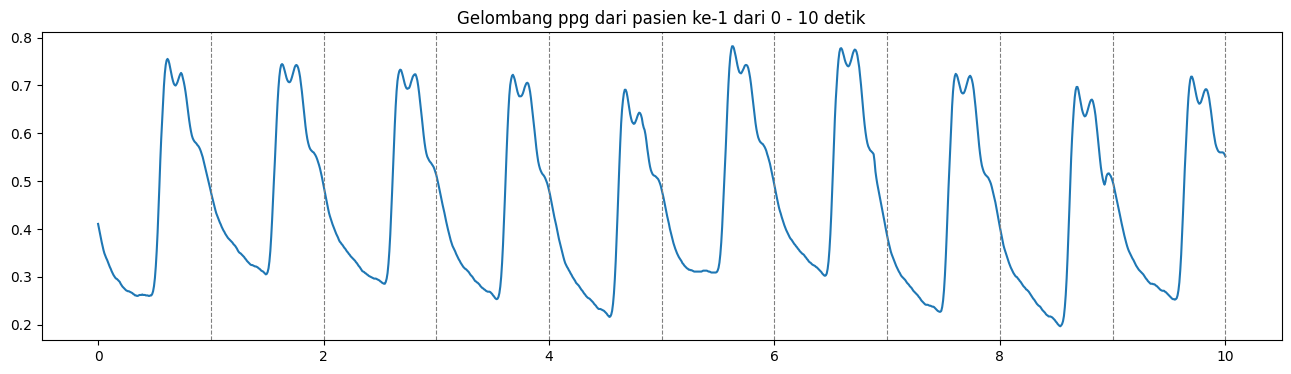

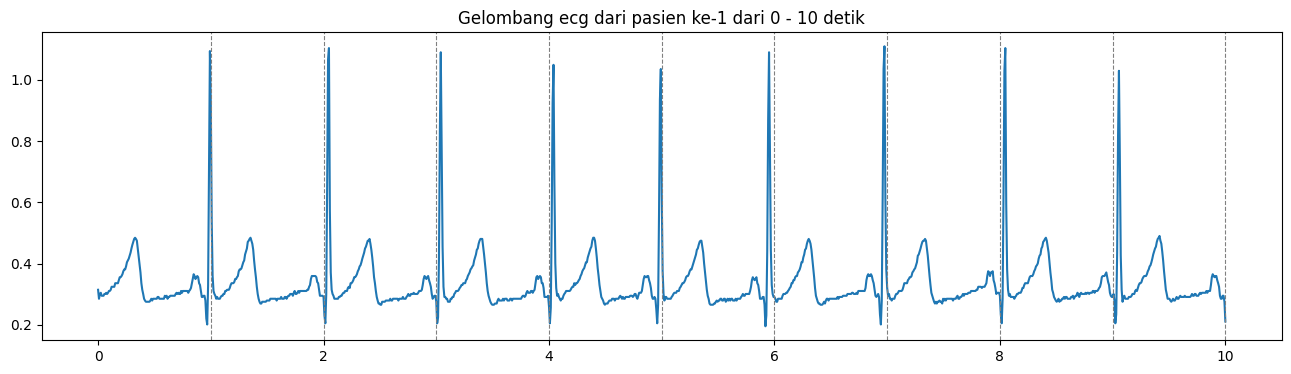

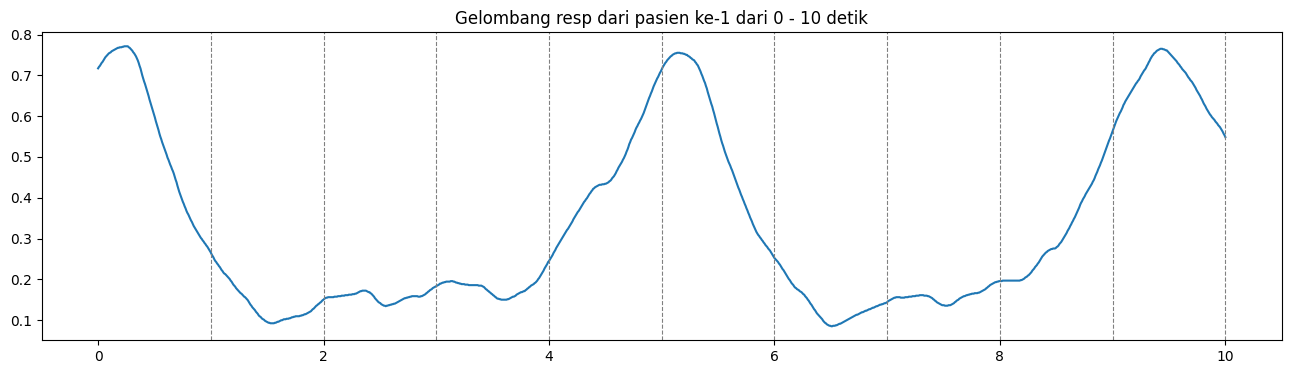

In [10]:
for i in df.columns[1:-1]:
    show_wave_from(df, fitur=i, sample_rate=125)

## AF VS Non-AF Wave

Non-AF Wave:


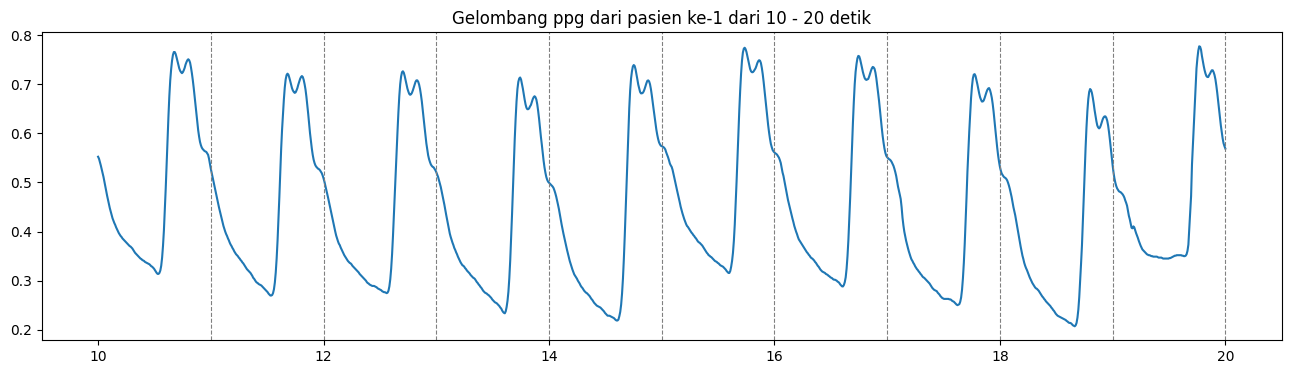

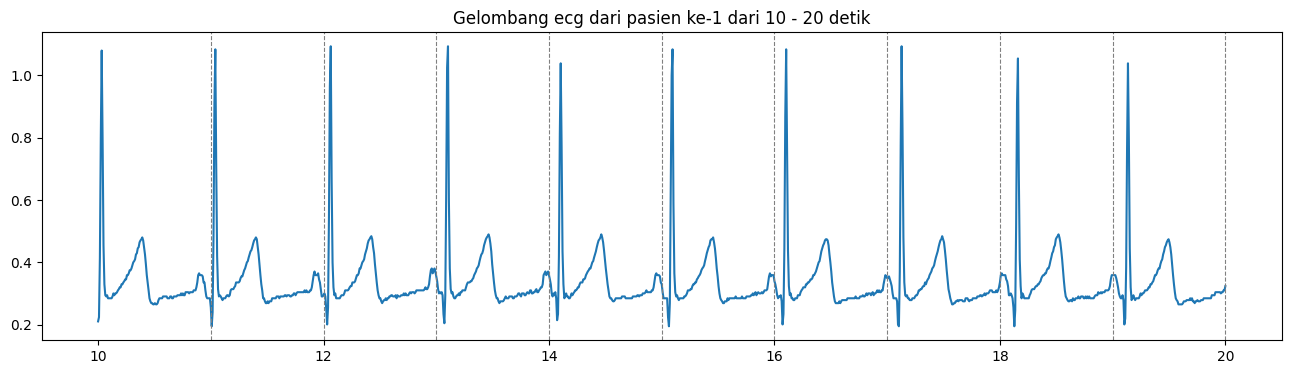

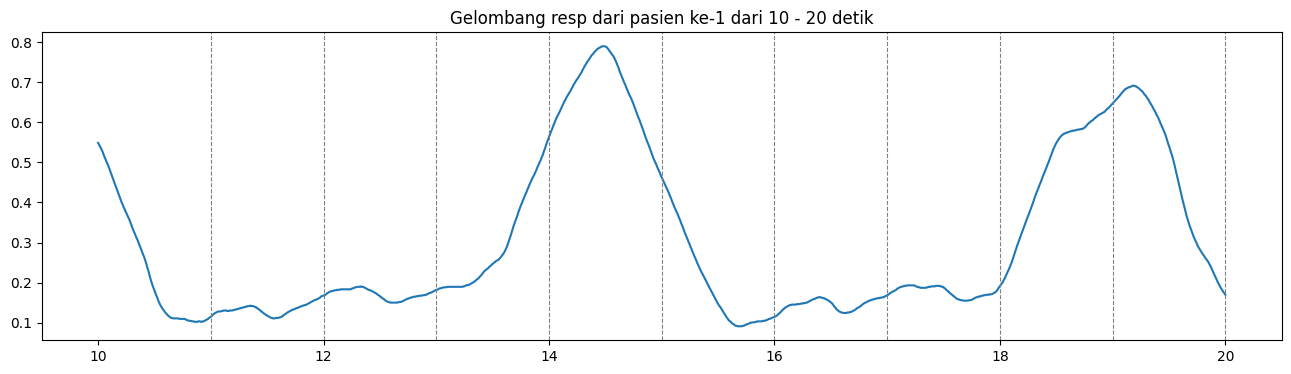

AF Wave:


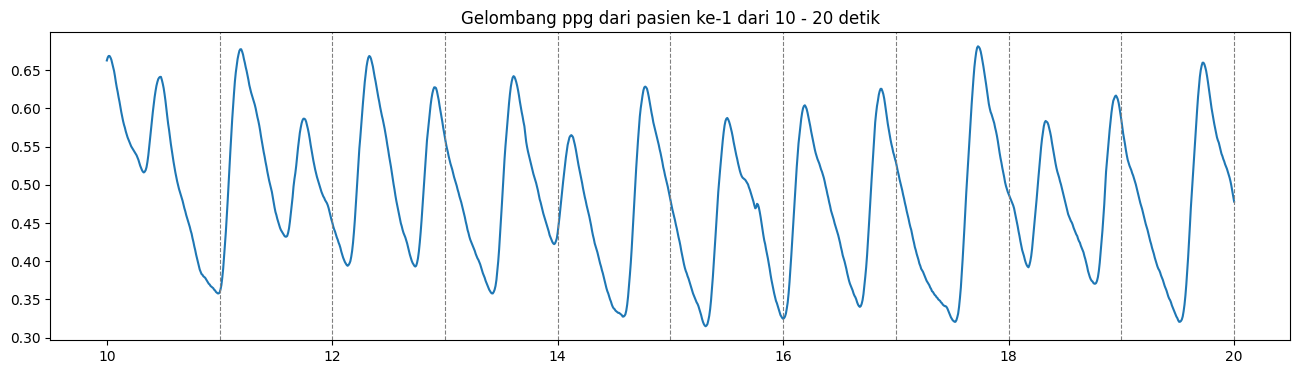

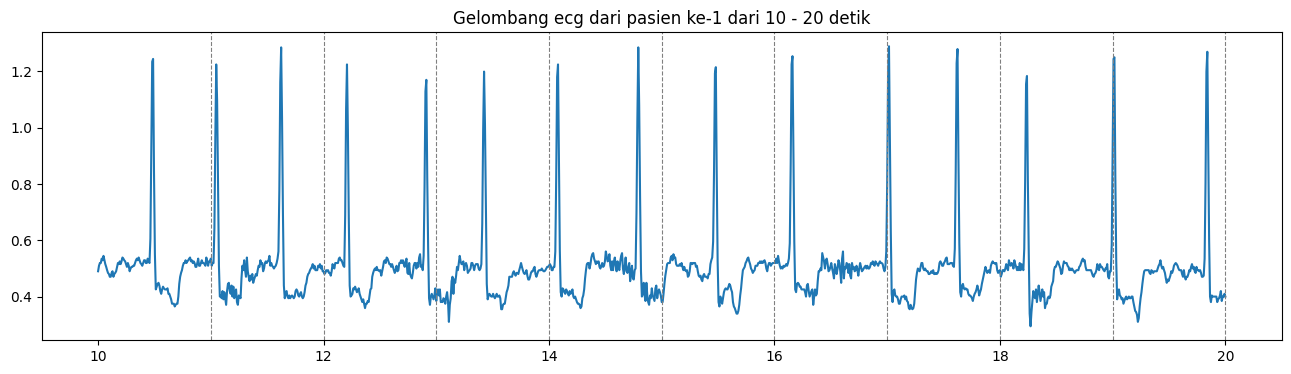

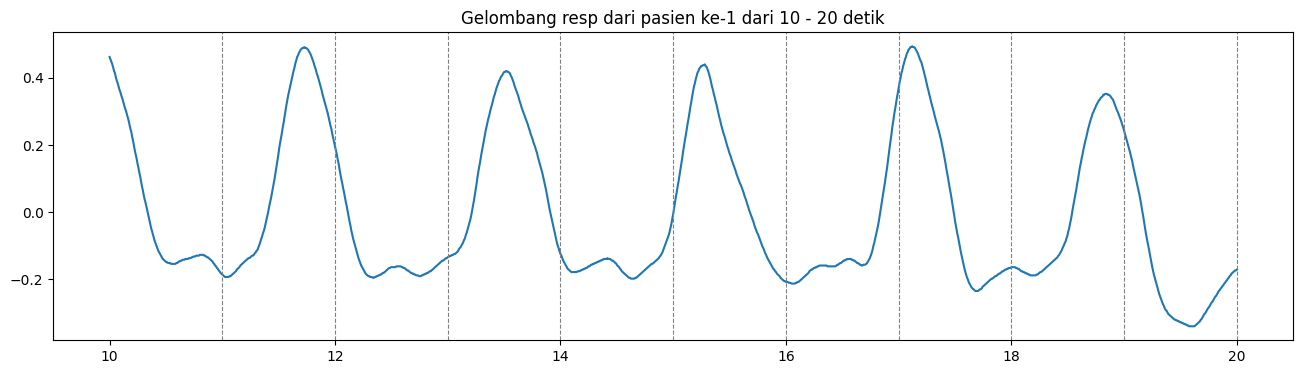

In [11]:
print('Non-AF Wave:')
for i in df.columns[1:-1]:
    show_wave_from(df, sample_rate=125, pasien_ke=1, s_start=10, s_stop=20, af_status=0, fitur=i)

print('AF Wave:')
for i in df.columns[1:-1]:
    show_wave_from(df, sample_rate=125, pasien_ke=1, s_start=10, s_stop=20, af_status=1, fitur=i)

# Praprocessing

## Imputation: Interpolation

In [12]:
df['ppg'] = df['ppg'].interpolate()
df['ecg'] = df['ecg'].interpolate()
df['resp'] = df['resp'].interpolate()

df.isna().sum()

time      0
ppg       0
ecg       0
resp      0
status    0
dtype: int64

## Set Window Size

In [13]:
sampling_rate = 125
window_size = sampling_rate    # 125 segment per window
n_features = 3  # PPG, ECG, and RESP

# Extract PPG, ECG, and RESP signals
ppg_signal = df['ppg'].values
ecg_signal = df['ecg'].values
resp_signal = df['resp'].values
n_windows = len(ppg_signal) // window_size

# Create windows for all three features
windows_list = []
for i in range(n_windows):
    start = i * window_size
    end = start + window_size
    ppg_window = ppg_signal[start:end]
    ecg_window = ecg_signal[start:end]
    resp_window = resp_signal[start:end]
    # Stack PPG, ECG, and RESP as separate features
    combined_window = np.column_stack([ppg_window, ecg_window, resp_window])
    windows_list.append(combined_window)

# Convert to array: shape will be (n_windows, 125, 3)
windows_array = np.array(windows_list)
print(f"Windows shape: {windows_array.shape}")

# Flatten for DataFrame storage: each row = 375 values (125*3)
df_window = pd.DataFrame(windows_array.reshape(n_windows, -1))
df_window

Windows shape: (42000, 125, 3)


,0,1,2,3,4,5,6,7,8,9,...,365,366,367,368,369,370,371,372,373,374
0,0.410557,0.314453,0.717097,0.400782,0.285156,0.720787,0.391007,0.300781,0.723247,0.382209,...,0.280443,0.503421,0.330078,0.276753,0.494624,0.708984,0.273063,0.486804,1.093750,0.269373
1,0.478006,0.919922,0.265683,0.470186,0.539062,0.260763,0.462366,0.359375,0.257073,0.454545,...,0.142681,0.519062,0.294922,0.143911,0.510264,0.294922,0.146371,0.500489,0.294922,0.148831
2,0.490714,0.291016,0.150062,0.480938,0.230469,0.152522,0.470186,0.205078,0.153752,0.460411,...,0.178352,0.529814,0.291016,0.179582,0.524927,0.294922,0.180812,0.519062,0.294922,0.182042
3,0.513196,0.275391,0.183272,0.505376,0.205078,0.184502,0.496579,0.224609,0.185732,0.487781,...,0.230012,0.500489,0.291016,0.233702,0.495601,0.291016,0.237392,0.488759,0.294922,0.242312
4,0.480938,0.259766,0.244772,0.473118,0.205078,0.248462,0.463343,0.255859,0.252153,0.454545,...,0.696187,0.500489,0.560547,0.701107,0.495601,0.935547,0.706027,0.489736,1.035156,0.709717
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
41995,0.456500,0.115234,0.420332,0.451613,0.111328,0.423265,0.448680,0.105469,0.427175,0.444770,...,0.374389,0.531769,0.166016,0.375367,0.520039,0.166016,0.376344,0.511241,0.160156,0.376344
41996,0.504399,0.160156,0.377322,0.498534,0.160156,0.379277,0.492669,0.175781,0.380254,0.488759,...,0.268817,0.372434,0.140625,0.260997,0.372434,0.134766,0.253177,0.371457,0.134766,0.246334
41997,0.371457,0.134766,0.239492,0.371457,0.134766,0.232649,0.371457,0.130859,0.226784,0.371457,...,0.115347,0.592375,-0.029297,0.113392,0.590420,-0.224609,0.112414,0.586510,-0.498047,0.110459
41998,0.581623,-0.498047,0.109482,0.575758,-0.349609,0.107527,0.567937,-0.148438,0.106549,0.560117,...,0.368524,0.393939,0.140625,0.366569,0.391007,0.156250,0.365591,0.390029,0.144531,0.363636


In [14]:
# jml kolom
len(df_window.iloc[0,:])

375

### Visualisasi

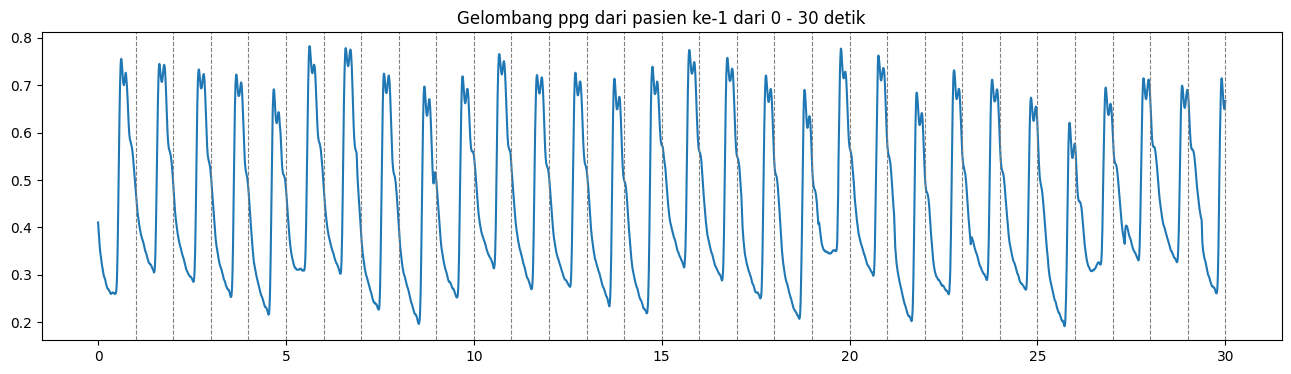

In [15]:
# Visualize ppg 30s (1 row df_window)
show_wave_from(df, sample_rate=125, s_start=0, s_stop=30)

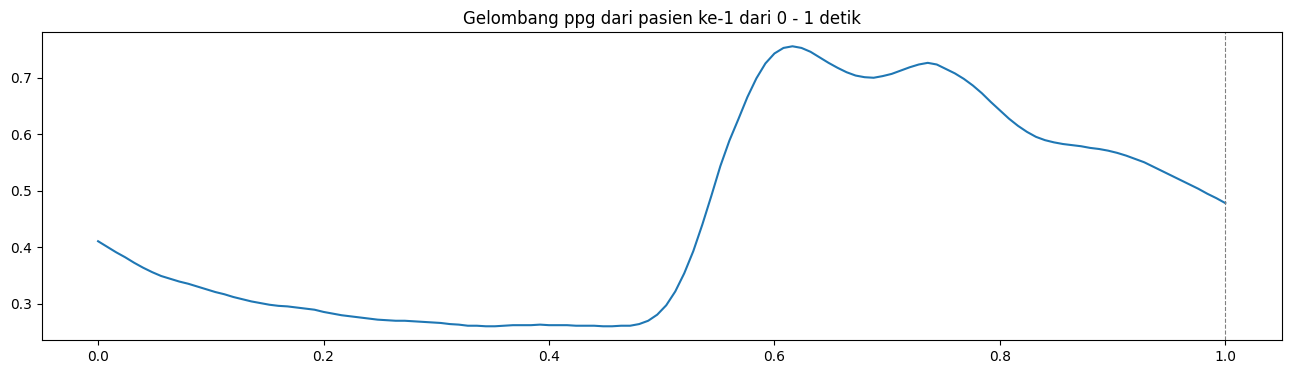

In [16]:
show_wave_from(df, sample_rate=125, s_start=0, s_stop=1)

## Add Label

In [17]:
status_array = df['status'].values
df_label = []

# Vote majority label per window
for i in range(n_windows):
    start = i * window_size
    end = start + window_size
    window_status = status_array[start:end]
    label = mode(window_status, keepdims=False).mode
    df_label.append(label)

df_label = pd.Series(df_label)
df_label

0        0
1        0
2        0
3        0
4        0
        ..
41995    1
41996    1
41997    1
41998    1
41999    1
Length: 42000, dtype: int64

In [18]:
df_label[df_label==1]

19200    1
19201    1
19202    1
19203    1
19204    1
        ..
41995    1
41996    1
41997    1
41998    1
41999    1
Length: 22800, dtype: int64

## Train Test Split

In [19]:
X_train, X_temp, y_train, y_temp = train_test_split(df_window, df_label, test_size=0.3, random_state=7, stratify=df_label)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp)

X_test

,0,1,2,3,4,5,6,7,8,9,...,365,366,367,368,369,370,371,372,373,374
21268,0.278431,0.496063,0.492744,0.301961,0.496063,0.492750,0.329412,0.527559,0.492756,0.364706,...,0.493484,0.250980,0.496063,0.493491,0.250980,0.527559,0.493497,0.250980,0.488189,0.493503
40222,0.520039,0.430341,-0.168675,0.520039,0.385449,-0.165663,0.520039,0.379257,-0.159639,0.519062,...,-0.415663,0.489736,0.385449,-0.418675,0.488759,0.390093,-0.421687,0.488759,0.399381,-0.427711
13682,0.662745,0.476562,0.989620,0.654902,0.476562,0.989620,0.650980,0.476562,0.989620,0.650980,...,0.989634,0.682353,0.437500,0.989634,0.682353,0.453125,0.989634,0.682353,0.476562,0.989634
29424,0.512219,0.580078,0.603128,0.506354,0.544922,0.605083,0.501466,0.525391,0.607038,0.495601,...,0.456500,0.450635,0.394531,0.469208,0.450635,0.400391,0.482893,0.451613,0.394531,0.495601
40942,0.441838,0.115234,0.305963,0.436950,0.134766,0.305963,0.434995,0.134766,0.305963,0.436950,...,0.302053,0.059629,0.125000,0.302053,0.082111,0.115234,0.303030,0.105572,0.121094,0.304008
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16982,0.580392,0.546875,0.583719,0.572549,0.562500,0.583717,0.568627,0.570312,0.583716,0.560784,...,0.583513,0.337255,0.585938,0.583511,0.333333,0.601562,0.583509,0.333333,0.593750,0.583507
749,0.497556,0.291016,0.168512,0.491691,0.294922,0.169742,0.484848,0.285156,0.172202,0.477028,...,0.177122,0.491691,0.304688,0.179582,0.486804,0.279297,0.180812,0.481916,0.275391,0.183272
9590,0.662745,1.500000,0.000000,0.643137,1.312500,0.000000,0.623529,1.085938,0.000000,0.603922,...,0.000000,0.364706,0.867188,0.000000,0.356863,0.867188,0.000000,0.349020,0.867188,0.000000
19587,0.633431,0.390625,-0.176039,0.638319,0.380859,-0.173594,0.641251,0.416016,-0.173594,0.641251,...,0.733496,0.446725,0.470703,0.743276,0.440860,0.470703,0.750611,0.434995,0.470703,0.757946


## Preprocess Pipeline

In [20]:
# Reshape data untuk Independent Feature Extraction (IFE)
# Setiap sinyal dipisahkan menjadi input terpisah
# PPG: kolom 0-124, ECG: kolom 125-249, RESP: kolom 250-374

def split_signals(X):
    """Split combined signals into separate PPG, ECG, and RESP arrays"""
    X_values = X.values if hasattr(X, 'values') else X
    ppg = X_values[:, :125].reshape(-1, 125, 1)
    ecg = X_values[:, 125:250].reshape(-1, 125, 1)
    resp = X_values[:, 250:375].reshape(-1, 125, 1)
    return ppg, ecg, resp

# Split signals untuk train, val, dan test
X_train_ppg, X_train_ecg, X_train_resp = split_signals(X_train)
X_val_ppg, X_val_ecg, X_val_resp = split_signals(X_val)
X_test_ppg, X_test_ecg, X_test_resp = split_signals(X_test)

print(f"✅ Data separated into individual signals:")
print(f"   PPG shape: {X_train_ppg.shape}")
print(f"   ECG shape: {X_train_ecg.shape}")
print(f"   RESP shape: {X_train_resp.shape}")

✅ Data separated into individual signals:
   PPG shape: (29400, 125, 1)
   ECG shape: (29400, 125, 1)
   RESP shape: (29400, 125, 1)


# Ekstraksi Fitur dengan Independent Feature Extraction (IFE)

Pada pendekatan ini, ketiga sinyal fisiologis (PPG, ECG, RESP) diproses secara terpisah menggunakan model LSTM yang berbeda. Setiap model LSTM menghasilkan vektor fitur mandiri yang menggambarkan karakteristik masing-masing sinyal. Vektor fitur dari ketiga sinyal kemudian digabungkan (feature concatenation) dan diberikan sebagai input ke classifier SVM.

## LSTM Model untuk Setiap Sinyal (PPG, ECG, RESP)

In [21]:
def build_single_signal_model(n_timesteps=125, signal_name='signal'):
    """Build LSTM model for single physiological signal"""
    model = Sequential([
        Input(shape=(n_timesteps, 1)),
        LSTM(64, name=f'lstm_{signal_name}'),
        Dropout(0.3),
        Dense(32, activation='relu', name=f'dense_{signal_name}'),
        Dense(1, activation='sigmoid')
    ], name=f'model_{signal_name}')

    model.compile(optimizer='adam',
                  loss='binary_crossentropy',
                  metrics=['accuracy', 'recall'])
    return model

print("✅ Model builder for independent signal processing created")

✅ Model builder for independent signal processing created


In [22]:
# Train LSTM model untuk setiap sinyal secara terpisah
tf.compat.v1.enable_eager_execution()

print("="*60)
print("Training LSTM for PPG Signal")
print("="*60)
model_ppg = build_single_signal_model(n_timesteps=125, signal_name='ppg')
history_ppg = model_ppg.fit(
    X_train_ppg, y_train,
    epochs=60,
    batch_size=64,
    validation_data=(X_val_ppg, y_val),
    verbose=1
)
print(f"✅ PPG model training completed. Final val_loss: {history_ppg.history['val_loss'][-1]:.4f}\n")

print("="*60)
print("Training LSTM for ECG Signal")
print("="*60)
model_ecg = build_single_signal_model(n_timesteps=125, signal_name='ecg')
history_ecg = model_ecg.fit(
    X_train_ecg, y_train,
    epochs=60,
    batch_size=64,
    validation_data=(X_val_ecg, y_val),
    verbose=1
)
print(f"✅ ECG model training completed. Final val_loss: {history_ecg.history['val_loss'][-1]:.4f}\n")

print("="*60)
print("Training LSTM for RESP Signal")
print("="*60)
model_resp = build_single_signal_model(n_timesteps=125, signal_name='resp')
history_resp = model_resp.fit(
    X_train_resp, y_train,
    epochs=60,
    batch_size=64,
    validation_data=(X_val_resp, y_val),
    verbose=1
)
print(f"✅ RESP model training completed. Final val_loss: {history_resp.history['val_loss'][-1]:.4f}\n")

print("="*60)
print("All three independent LSTM models trained successfully!")
print("="*60)

Training LSTM for PPG Signal


I0000 00:00:1764773069.398330      19 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15513 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0


Epoch 1/60


I0000 00:00:1764773072.708558      60 cuda_dnn.cc:529] Loaded cuDNN version 90300


460/460 ━━━━━━━━━━━━━━━━━━━━ 8s 10ms/step - accuracy: 0.5424 - loss: 0.6895 - recall: 0.8865 - val_accuracy: 0.5602 - val_loss: 0.6638 - val_recall: 0.9854
Epoch 2/60
460/460 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step - accuracy: 0.5740 - loss: 0.6667 - recall: 0.8282 - val_accuracy: 0.5816 - val_loss: 0.6446 - val_recall: 0.9827
Epoch 3/60
460/460 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step - accuracy: 0.5879 - loss: 0.6443 - recall: 0.7159 - val_accuracy: 0.6133 - val_loss: 0.6214 - val_recall: 0.6845
Epoch 4/60
460/460 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step - accuracy: 0.6070 - loss: 0.6301 - recall: 0.6679 - val_accuracy: 0.6227 - val_loss: 0.6475 - val_recall: 0.7678
Epoch 5/60
460/460 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step - accuracy: 0.6170 - loss: 0.6435 - recall: 0.7557 - val_accuracy: 0.6284 - val_loss: 0.6029 - val_recall: 0.7316
Epoch 6/60
460/460 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step - accuracy: 0.6273 - loss: 0.6078 - recall: 0.6899 - val_accuracy: 0.6379 - val_loss: 0.5843 - val_recall: 0.7439
Epoch 7/60
460

In [ ]:
# Save trained LSTM models
os.makedirs('models/SVM', exist_ok=True)
timestamp = dt.now().strftime('%d%m%Y_%H%M%S')

model_ppg_path = f'models/SVM/lstm_ppg_{timestamp}.h5'
model_ecg_path = f'models/SVM/lstm_ecg_{timestamp}.h5'
model_resp_path = f'models/SVM/lstm_resp_{timestamp}.h5'

model_ppg.save(model_ppg_path)
model_ecg.save(model_ecg_path)
model_resp.save(model_resp_path)

print(f'✅ LSTM models saved:')
print(f'   PPG:  {model_ppg_path}')
print(f'   ECG:  {model_ecg_path}')
print(f'   RESP: {model_resp_path}')

✅ LSTM models saved:
   PPG:  models_ife/lstm_ppg_03122025_145730.h5
   ECG:  models_ife/lstm_ecg_03122025_145730.h5
   RESP: models_ife/lstm_resp_03122025_145730.h5


## Visualisasi Hasil Training

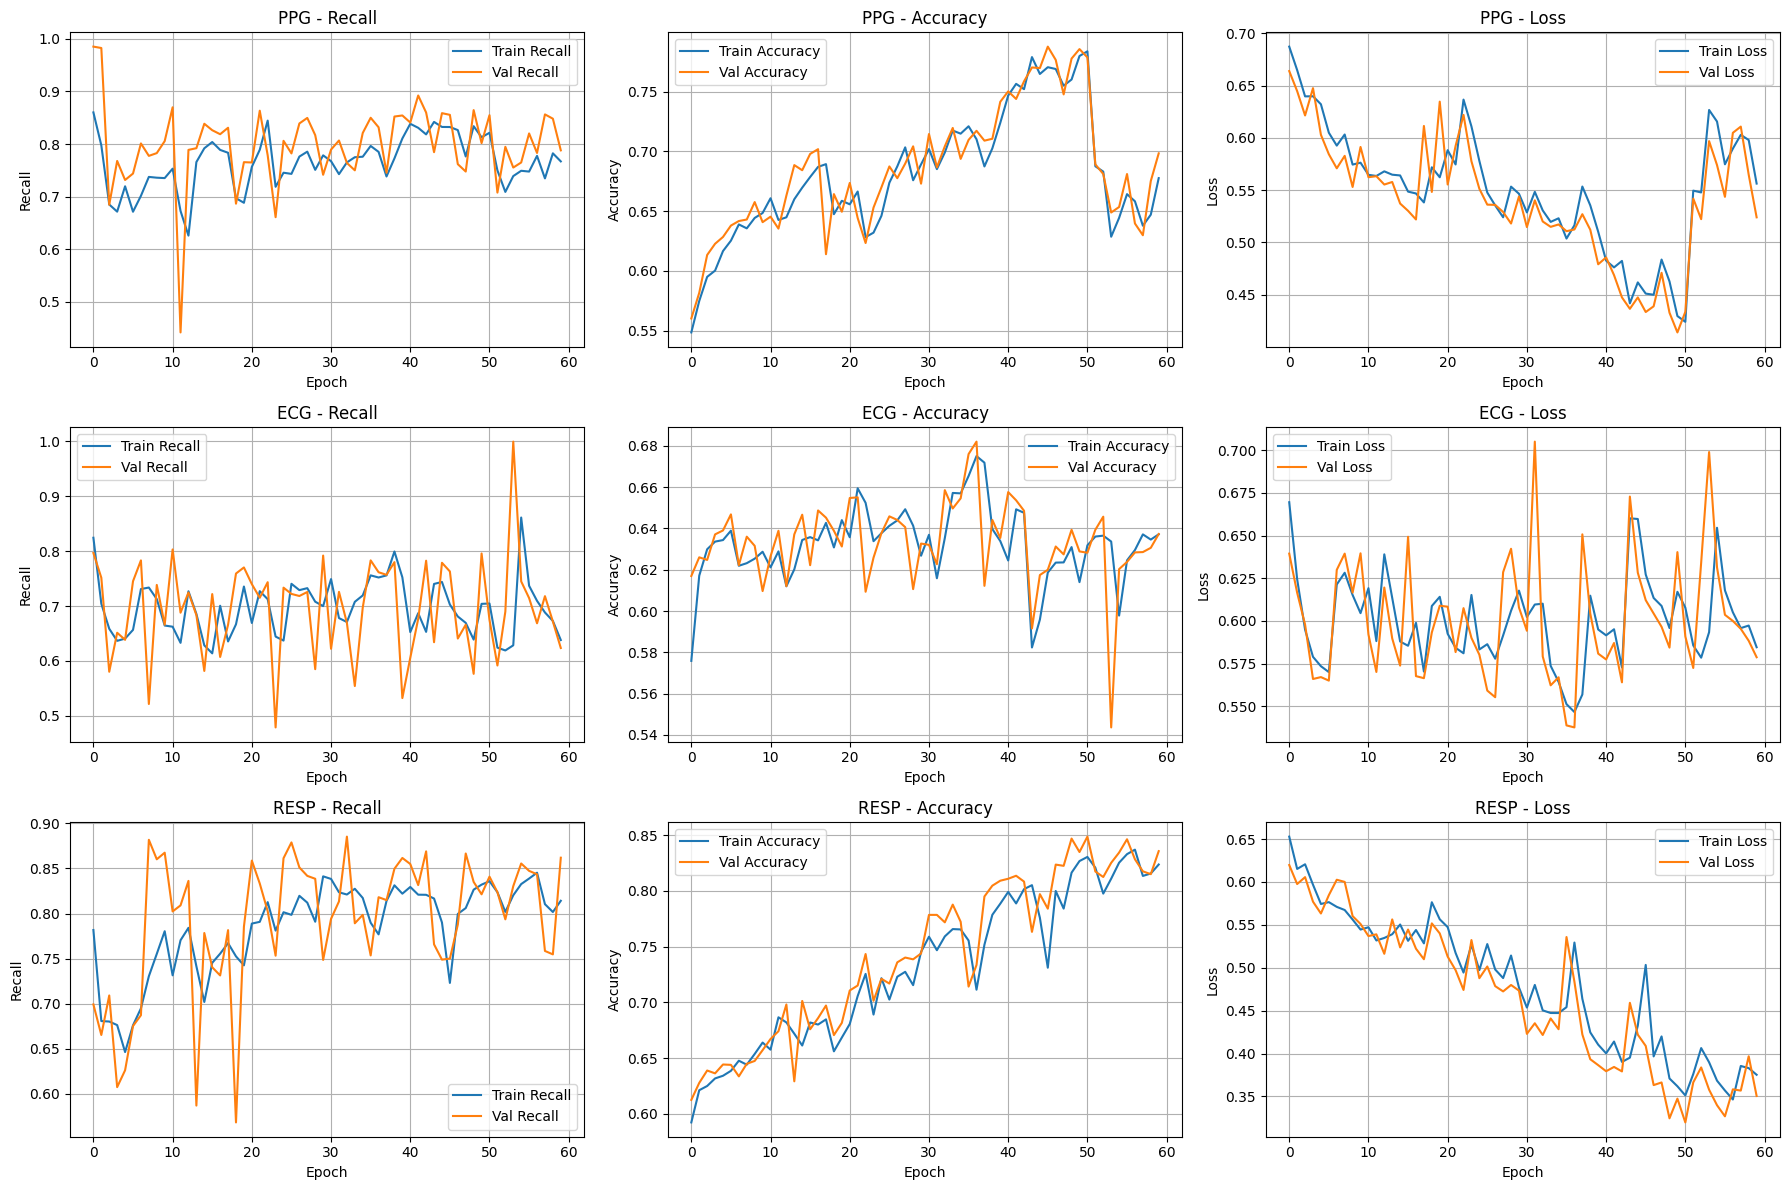

In [24]:
# Plot training history untuk ketiga model
fig, axes = plt.subplots(3, 3, figsize=(18, 12))

# PPG Model
axes[0, 0].plot(history_ppg.history['recall'], label='Train Recall')
axes[0, 0].plot(history_ppg.history['val_recall'], label='Val Recall')
axes[0, 0].set_title('PPG - Recall')
axes[0, 0].set_xlabel('Epoch')
axes[0, 0].set_ylabel('Recall')
axes[0, 0].legend()
axes[0, 0].grid(True)

axes[0, 1].plot(history_ppg.history['accuracy'], label='Train Accuracy')
axes[0, 1].plot(history_ppg.history['val_accuracy'], label='Val Accuracy')
axes[0, 1].set_title('PPG - Accuracy')
axes[0, 1].set_xlabel('Epoch')
axes[0, 1].set_ylabel('Accuracy')
axes[0, 1].legend()
axes[0, 1].grid(True)

axes[0, 2].plot(history_ppg.history['loss'], label='Train Loss')
axes[0, 2].plot(history_ppg.history['val_loss'], label='Val Loss')
axes[0, 2].set_title('PPG - Loss')
axes[0, 2].set_xlabel('Epoch')
axes[0, 2].set_ylabel('Loss')
axes[0, 2].legend()
axes[0, 2].grid(True)

# ECG Model
axes[1, 0].plot(history_ecg.history['recall'], label='Train Recall')
axes[1, 0].plot(history_ecg.history['val_recall'], label='Val Recall')
axes[1, 0].set_title('ECG - Recall')
axes[1, 0].set_xlabel('Epoch')
axes[1, 0].set_ylabel('Recall')
axes[1, 0].legend()
axes[1, 0].grid(True)

axes[1, 1].plot(history_ecg.history['accuracy'], label='Train Accuracy')
axes[1, 1].plot(history_ecg.history['val_accuracy'], label='Val Accuracy')
axes[1, 1].set_title('ECG - Accuracy')
axes[1, 1].set_xlabel('Epoch')
axes[1, 1].set_ylabel('Accuracy')
axes[1, 1].legend()
axes[1, 1].grid(True)

axes[1, 2].plot(history_ecg.history['loss'], label='Train Loss')
axes[1, 2].plot(history_ecg.history['val_loss'], label='Val Loss')
axes[1, 2].set_title('ECG - Loss')
axes[1, 2].set_xlabel('Epoch')
axes[1, 2].set_ylabel('Loss')
axes[1, 2].legend()
axes[1, 2].grid(True)

# RESP Model
axes[2, 0].plot(history_resp.history['recall'], label='Train Recall')
axes[2, 0].plot(history_resp.history['val_recall'], label='Val Recall')
axes[2, 0].set_title('RESP - Recall')
axes[2, 0].set_xlabel('Epoch')
axes[2, 0].set_ylabel('Recall')
axes[2, 0].legend()
axes[2, 0].grid(True)

axes[2, 1].plot(history_resp.history['accuracy'], label='Train Accuracy')
axes[2, 1].plot(history_resp.history['val_accuracy'], label='Val Accuracy')
axes[2, 1].set_title('RESP - Accuracy')
axes[2, 1].set_xlabel('Epoch')
axes[2, 1].set_ylabel('Accuracy')
axes[2, 1].legend()
axes[2, 1].grid(True)

axes[2, 2].plot(history_resp.history['loss'], label='Train Loss')
axes[2, 2].plot(history_resp.history['val_loss'], label='Val Loss')
axes[2, 2].set_title('RESP - Loss')
axes[2, 2].set_xlabel('Epoch')
axes[2, 2].set_ylabel('Loss')
axes[2, 2].legend()
axes[2, 2].grid(True)

plt.tight_layout()
plt.show()

In [25]:
# Build Feature Extractors dari setiap LSTM yang sudah dilatih
# Menggunakan output dari last dense layer (Dense 32) sebagai fitur

lstm_ppg_extractor = Model(inputs=model_ppg.inputs, outputs=model_ppg.get_layer('dense_ppg').output)
lstm_ecg_extractor = Model(inputs=model_ecg.inputs, outputs=model_ecg.get_layer('dense_ecg').output)
lstm_resp_extractor = Model(inputs=model_resp.inputs, outputs=model_resp.get_layer('dense_resp').output)

print("✅ LSTM Feature Extractors created for all signals")
print(f"   PPG Extractor:  {lstm_ppg_extractor.output_shape}")
print(f"   ECG Extractor:  {lstm_ecg_extractor.output_shape}")
print(f"   RESP Extractor: {lstm_resp_extractor.output_shape}")

✅ LSTM Feature Extractors created for all signals
   PPG Extractor:  (None, 32)
   ECG Extractor:  (None, 32)
   RESP Extractor: (None, 32)


## Ekstraksi Fitur dari Setiap LSTM dan Feature Concatenation

In [26]:
# Extract features dari setiap sinyal secara terpisah
print("Extracting features from PPG signal...")
X_train_ppg_feat = lstm_ppg_extractor.predict(X_train_ppg, verbose=0)
X_val_ppg_feat = lstm_ppg_extractor.predict(X_val_ppg, verbose=0)
X_test_ppg_feat = lstm_ppg_extractor.predict(X_test_ppg, verbose=0)

print("Extracting features from ECG signal...")
X_train_ecg_feat = lstm_ecg_extractor.predict(X_train_ecg, verbose=0)
X_val_ecg_feat = lstm_ecg_extractor.predict(X_val_ecg, verbose=0)
X_test_ecg_feat = lstm_ecg_extractor.predict(X_test_ecg, verbose=0)

print("Extracting features from RESP signal...")
X_train_resp_feat = lstm_resp_extractor.predict(X_train_resp, verbose=0)
X_val_resp_feat = lstm_resp_extractor.predict(X_val_resp, verbose=0)
X_test_resp_feat = lstm_resp_extractor.predict(X_test_resp, verbose=0)

# Concatenate features dari ketiga sinyal
X_train_xtract = np.concatenate([X_train_ppg_feat, X_train_ecg_feat, X_train_resp_feat], axis=1)
X_val_xtract = np.concatenate([X_val_ppg_feat, X_val_ecg_feat, X_val_resp_feat], axis=1)
X_test_xtract = np.concatenate([X_test_ppg_feat, X_test_ecg_feat, X_test_resp_feat], axis=1)

print(f"\n✅ Independent Feature Extraction completed:")
print(f"   PPG features:  {X_train_ppg_feat.shape[1]} dimensions")
print(f"   ECG features:  {X_train_ecg_feat.shape[1]} dimensions")
print(f"   RESP features: {X_train_resp_feat.shape[1]} dimensions")
print(f"\n   Combined features shape:")
print(f"   Train: {X_train_xtract.shape} (32+32+32 = 96 features)")
print(f"   Val:   {X_val_xtract.shape}")
print(f"   Test:  {X_test_xtract.shape}")

Extracting features from PPG signal...


/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning:

The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor']
Received: inputs=Tensor(shape=(32, 125, 1))

/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning:

The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor']
Received: inputs=Tensor(shape=(None, 125, 1))



Extracting features from ECG signal...


/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning:

The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_5']
Received: inputs=Tensor(shape=(32, 125, 1))

/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning:

The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_5']
Received: inputs=Tensor(shape=(None, 125, 1))



Extracting features from RESP signal...


/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning:

The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_10']
Received: inputs=Tensor(shape=(32, 125, 1))

/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning:

The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_10']
Received: inputs=Tensor(shape=(None, 125, 1))




✅ Independent Feature Extraction completed:
   PPG features:  32 dimensions
   ECG features:  32 dimensions
   RESP features: 32 dimensions

   Combined features shape:
   Train: (29400, 96) (32+32+32 = 96 features)
   Val:   (6300, 96)
   Test:  (6300, 96)


# Classifier: SVM dengan Fitur Gabungan (IFE)

## Hyperparameter Tuning dengan Grid Search

### Tuning

In [27]:
param_grid = {
    'C': [0.01, 0.1, 1, 10, 100],
    'kernel': ['rbf', 'linear', 'poly', 'sigmoid'],
    'gamma': ['scale', 'auto', 0.001, 0.01, 0.1],
    'degree': [2, 3, 4],            # relevan untuk kernel='poly'
    'class_weight': [None, 'balanced']
}

In [28]:
svc = SVC(random_state=77)  # probability=False by default
model_grid = GridSearchCV(
    estimator=svc,
    param_grid=param_grid,
    scoring='accuracy',   # atau 'f1'/'recall' jika lebih cocok untuk dataset imbalance
    cv=3,
    verbose=2,
    n_jobs=-1
)

In [29]:
print("Starting GridSearchCV...")
model_grid.fit(X_train_xtract, y_train)
print("GridSearchCV Done")

Starting GridSearchCV...
Fitting 3 folds for each of 600 candidates, totalling 1800 fits
[CV] END C=0.01, class_weight=None, degree=2, gamma=scale, kernel=rbf; total time=  58.7s
[CV] END C=0.01, class_weight=None, degree=2, gamma=scale, kernel=poly; total time=  39.5s
[CV] END C=0.01, class_weight=None, degree=2, gamma=scale, kernel=sigmoid; total time= 1.2min
[CV] END C=0.01, class_weight=None, degree=2, gamma=auto, kernel=linear; total time=  23.8s
[CV] END C=0.01, class_weight=None, degree=2, gamma=auto, kernel=poly; total time=  50.3s
[CV] END C=0.01, class_weight=None, degree=2, gamma=auto, kernel=sigmoid; total time= 1.1min
[CV] END C=0.01, class_weight=None, degree=2, gamma=0.001, kernel=linear; total time=  20.3s
[CV] END C=0.01, class_weight=None, degree=2, gamma=0.001, kernel=linear; total time=  25.6s
[CV] END C=0.01, class_weight=None, degree=2, gamma=0.001, kernel=poly; total time= 1.2min
[CV] END C=0.01, class_weight=None, degree=2, gamma=0.001, kernel=sigmoid; total tim

In [30]:
print("Best params:", model_grid.best_params_)
print("Skor cross-validation terbaik:", model_grid.best_score_)

best_params_grid = model_grid.best_params_

Best params: {'C': 100, 'class_weight': None, 'degree': 2, 'gamma': 0.1, 'kernel': 'rbf'}
Skor cross-validation terbaik: 0.9250340136054421


### Run Model

In [31]:
model_grid = SVC(**best_params_grid, probability=True, random_state=77)
model_grid.fit(X_train_xtract, y_train)


[CV] END C=100, class_weight=None, degree=2, gamma=scale, kernel=rbf; total time=  30.3s
[CV] END C=100, class_weight=None, degree=2, gamma=scale, kernel=poly; total time=  31.3s
[CV] END C=100, class_weight=None, degree=2, gamma=scale, kernel=poly; total time=  31.3s
[CV] END C=100, class_weight=None, degree=2, gamma=scale, kernel=poly; total time=  31.0s
[CV] END C=100, class_weight=None, degree=2, gamma=scale, kernel=sigmoid; total time=  32.3s
[CV] END C=100, class_weight=None, degree=2, gamma=scale, kernel=sigmoid; total time=  26.8s
[CV] END C=100, class_weight=None, degree=2, gamma=scale, kernel=sigmoid; total time=  27.6s
[CV] END C=100, class_weight=None, degree=2, gamma=auto, kernel=rbf; total time=  25.7s
[CV] END C=100, class_weight=None, degree=2, gamma=auto, kernel=rbf; total time=  26.4s
[CV] END C=100, class_weight=None, degree=2, gamma=auto, kernel=rbf; total time=  25.6s
[CV] END C=100, class_weight=None, degree=2, gamma=auto, kernel=linear; total time= 4.7min
[CV] E

SVC(C=100, degree=2, gamma=0.1, probability=True, random_state=77)

In [32]:
y_pred_best_grid = model_grid.predict(X_test_xtract)
y_prob_best_grid = model_grid.decision_function(X_test_xtract)

## Evaluasi Model GridSearch CV

### Metrik Evaluasi

In [33]:
acc_grid = accuracy_score(y_test, y_pred_best_grid)
prec_grid = precision_score(y_test, y_pred_best_grid)
rec_grid = recall_score(y_test, y_pred_best_grid)
f1s_grid = f1_score(y_test, y_pred_best_grid)
rocauc_grid = roc_auc_score(y_test, y_prob_best_grid)

print("Evaluasi Best SVC")
print(f"Accuracy:  {acc_grid:.4f}")
print(f"Precision: {prec_grid:.4f}")
print(f"Recall:    {rec_grid:.4f}")
print(f"F1 Score:  {f1s_grid:.4f}")
print(f"ROC AUC:   {rocauc_grid:.4f}\n")

print(classification_report(y_test, y_pred_best_grid))

Evaluasi Best SVC
Accuracy:  0.9340
Precision: 0.9513
Recall:    0.9257
F1 Score:  0.9384
ROC AUC:   0.9771

              precision    recall  f1-score   support

           0       0.91      0.94      0.93      2880
           1       0.95      0.93      0.94      3420

    accuracy                           0.93      6300
   macro avg       0.93      0.93      0.93      6300
weighted avg       0.93      0.93      0.93      6300



### ROC Curve

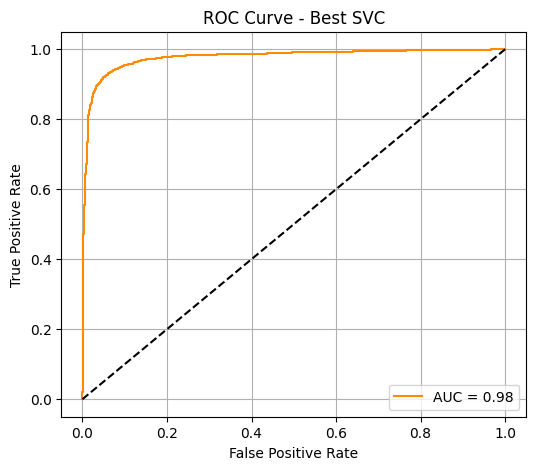

In [34]:
fpr, tpr, _ = roc_curve(y_test, y_prob_best_grid)
plt.figure(figsize=(6,5))
plt.plot(fpr, tpr, label=f"AUC = {rocauc_grid:.2f}", color='darkorange')
plt.plot([0,1],[0,1],'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - Best SVC')
plt.legend()
plt.grid(True)
plt.show()

### Confusion matrix

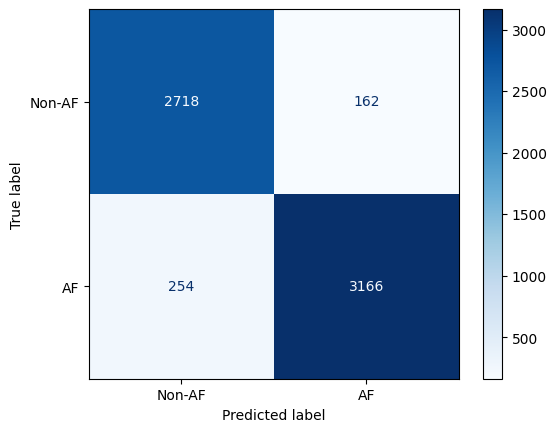

In [35]:
cm = confusion_matrix(y_test, y_pred_best_grid)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Non-AF','AF'])
disp.plot(cmap='Blues')
plt.show()

## Hyperparameter Tuning dengan Optuna

### Tuning

In [36]:
def objective(trial):
    # Define hyperparameter search space
    param = {
        'C': trial.suggest_float('C', 0.01, 100, log=True),
        'kernel': trial.suggest_categorical('kernel', ['rbf', 'linear', 'poly', 'sigmoid']),
        'gamma': trial.suggest_categorical('gamma', ['scale', 'auto', 0.001, 0.01, 0.1]),
        'degree': trial.suggest_int('degree', 2, 4),  # untuk kernel poly
        'class_weight': trial.suggest_categorical('class_weight', [None, 'balanced']),
        'random_state': 77
    }
    
    # Train model
    svc_optuna = SVC(**param)
    svc_optuna.fit(X_train_xtract, y_train)
    
    # Evaluate on validation set
    y_pred_val = svc_optuna.predict(X_val_xtract)
    accuracy = accuracy_score(y_val, y_pred_val)
    
    return accuracy

# Create study and optimize
print("Starting Optuna optimization...")
study = optuna.create_study(
    direction='maximize',
    sampler=TPESampler(seed=77)
)
study.optimize(objective, n_trials=100, show_progress_bar=True)
print("Optuna optimization Done")

[I 2025-12-03 22:24:19,742] A new study created in memory with name: no-name-f2be2a4b-20e1-4155-b3fc-ed81b05dd239


Starting Optuna optimization...


  0%|          | 0/100 [00:00<?, ?it/s]

[I 2025-12-03 22:28:09,644] Trial 0 finished with value: 0.8666666666666667 and parameters: {'C': 47.47184677446414, 'kernel': 'linear', 'gamma': 'scale', 'degree': 3, 'class_weight': 'balanced'}. Best is trial 0 with value: 0.8666666666666667.
[I 2025-12-03 22:28:32,066] Trial 1 finished with value: 0.8665079365079366 and parameters: {'C': 2.25904337744176, 'kernel': 'poly', 'gamma': 'auto', 'degree': 2, 'class_weight': 'balanced'}. Best is trial 0 with value: 0.8666666666666667.
[I 2025-12-03 22:29:35,517] Trial 2 finished with value: 0.7771428571428571 and parameters: {'C': 0.017992275660414364, 'kernel': 'sigmoid', 'gamma': 0.001, 'degree': 3, 'class_weight': 'balanced'}. Best is trial 0 with value: 0.8666666666666667.
[I 2025-12-03 22:29:56,493] Trial 3 finished with value: 0.8603174603174604 and parameters: {'C': 0.3489913256264903, 'kernel': 'linear', 'gamma': 'scale', 'degree': 3, 'class_weight': None}. Best is trial 0 with value: 0.8666666666666667.
[I 2025-12-03 22:30:21,246]

In [37]:
best_params_optuna = study.best_params
best_score = study.best_value

print(best_params_optuna)
print(best_score)

{'C': 93.15902759306859, 'kernel': 'rbf', 'gamma': 0.1, 'degree': 3, 'class_weight': None}
0.9307936507936508


### Run Model

In [38]:
model_optuna = SVC(**best_params_optuna)
model_optuna.fit(X_train_xtract, y_train)

SVC(C=93.15902759306859, gamma=0.1)

In [39]:
y_prob_optuna = model_optuna.decision_function(X_test_xtract)
y_pred_optuna = model_optuna.predict(X_test_xtract)
y_prob_optuna

array([-0.80209156,  2.15773728, -1.29316074, ..., -1.00551961,
        6.05097416,  1.12696431])

## Evaluasi Model Optuna

### Metrik Evaluasi

In [40]:
acc_optuna = accuracy_score(y_test, y_pred_optuna)
prec_optuna = precision_score(y_test, y_pred_optuna)
recall_optuna = recall_score(y_test, y_pred_optuna)
f1_optuna = f1_score(y_test, y_pred_optuna)
rocauc_optuna = roc_auc_score(y_test, y_prob_optuna)

print('SVC Evaluation (raw)')
print(f'Accuracy: {acc_optuna:.4f}')
print(f'Precision: {prec_optuna:.4f}')
print(f'Recall   : {recall_optuna:.4f}')
print(f'F1 Score : {f1_optuna:.4f}')
print(f'ROC AUC  : {rocauc_optuna:.4f}')

print(classification_report(y_test, y_pred_optuna))


SVC Evaluation (raw)
Accuracy: 0.9344
Precision: 0.9516
Recall   : 0.9263
F1 Score : 0.9388
ROC AUC  : 0.9771
              precision    recall  f1-score   support

           0       0.92      0.94      0.93      2880
           1       0.95      0.93      0.94      3420

    accuracy                           0.93      6300
   macro avg       0.93      0.94      0.93      6300
weighted avg       0.93      0.93      0.93      6300



### ROC Curve

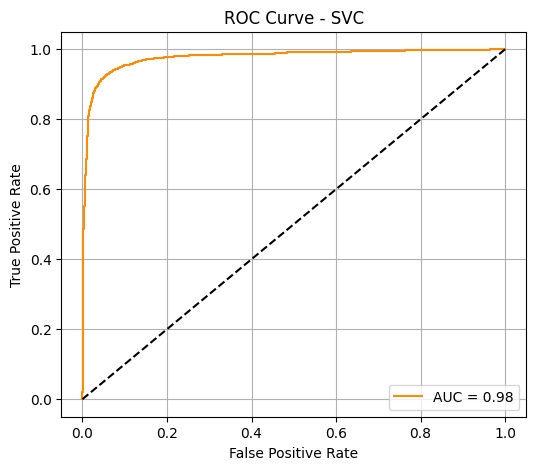

In [41]:
# ROC curve for raw SVC
fpr, tpr, _ = roc_curve(y_test, y_prob_optuna)
plt.figure(figsize=(6,5))
plt.plot(fpr, tpr, label=f"AUC = {rocauc_optuna:.2f}", color='darkorange')
plt.plot([0,1], [0,1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - SVC')
plt.legend()
plt.grid(True)
plt.show()

### Confusion Matrix

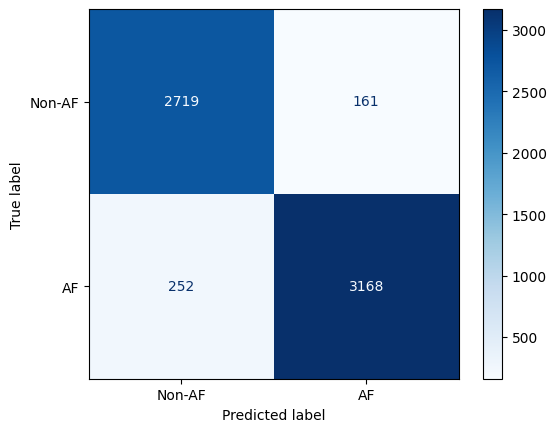

In [42]:
# Confusion matrix hybrid
cm = confusion_matrix(y_test, y_pred_optuna)
disp_cm = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Non-AF', 'AF'])
disp_cm.plot(cmap='Blues')

## Tanpa Hyperparameter Tuning

### Run Model

In [43]:
model_raw = SVC()

model_raw.fit(X_train_xtract, y_train)
model_raw

SVC()

In [44]:
y_prob_raw = model_raw.decision_function(X_test_xtract)
y_pred_raw = model_raw.predict(X_test_xtract)
y_prob_raw

array([-1.23728634,  2.30837099, -1.06754468, ..., -1.53770213,
        3.17256118,  1.37540228])

## Evaluasi Model Tanpa Hyperparamater Tuning

### Metrik Evaluasi

In [45]:
acc_raw = accuracy_score(y_test, y_pred_raw)
prec_raw = precision_score(y_test, y_pred_raw)
recall_raw = recall_score(y_test, y_pred_raw)
f1_raw = f1_score(y_test, y_pred_raw)
rocauc_raw = roc_auc_score(y_test, y_prob_raw)

print('SVC Evaluation (raw)')
print(f'Accuracy: {acc_raw:.4f}')
print(f'Precision: {prec_raw:.4f}')
print(f'Recall   : {recall_raw:.4f}')
print(f'F1 Score : {f1_raw:.4f}')
print(f'ROC AUC  : {rocauc_raw:.4f}')

print(classification_report(y_test, y_pred_raw))


SVC Evaluation (raw)
Accuracy: 0.8735
Precision: 0.9022
Recall   : 0.8602
F1 Score : 0.8807
ROC AUC  : 0.9463
              precision    recall  f1-score   support

           0       0.84      0.89      0.87      2880
           1       0.90      0.86      0.88      3420

    accuracy                           0.87      6300
   macro avg       0.87      0.87      0.87      6300
weighted avg       0.87      0.87      0.87      6300



### ROC Curve

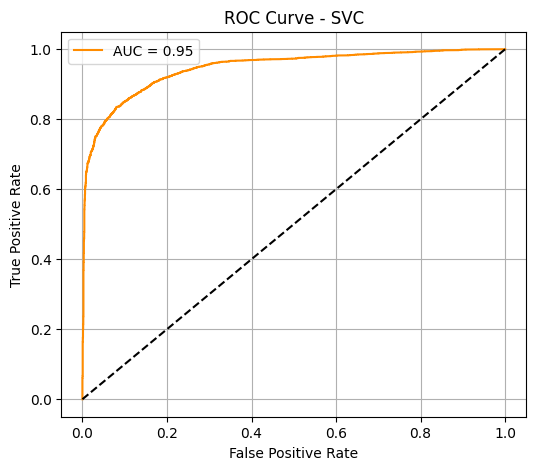

In [46]:
# ROC curve for raw SVC
fpr, tpr, _ = roc_curve(y_test, y_prob_raw)
plt.figure(figsize=(6,5))
plt.plot(fpr, tpr, label=f"AUC = {rocauc_raw:.2f}", color='darkorange')
plt.plot([0,1], [0,1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - SVC')
plt.legend()
plt.grid(True)
plt.show()

### Confusion Matrix

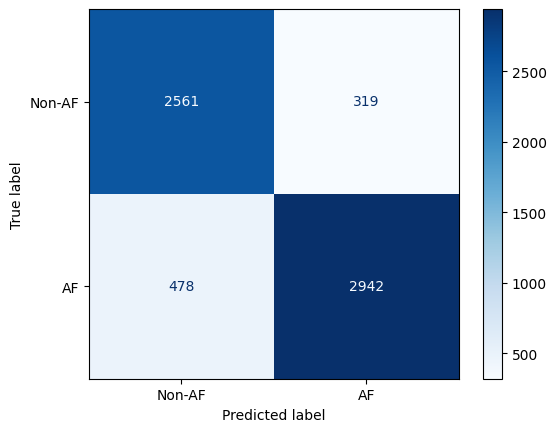

In [47]:
# Confusion matrix hybrid
cm = confusion_matrix(y_test, y_pred_raw)
disp_cm = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Non-AF', 'AF'])
disp_cm.plot(cmap='Blues')

# Evaluasi

## Histogram Perbandingan Accuracy

In [48]:
try:
    acc_dict = {
        'GridSearchCV': acc_grid,
        'Optuna': acc_optuna,
        'No Tuning': acc_raw
    }
except NameError:
    acc_dict = {}
    if 'y_pred_best_grid' in globals():
        acc_dict['GridSearchCV'] = accuracy_score(y_test, y_pred_best_grid)
    if 'y_pred_optuna' in globals():
        acc_dict['Optuna'] = accuracy_score(y_test, y_pred_optuna)
    if 'y_pred_raw' in globals():
        acc_dict['No Tuning'] = accuracy_score(y_test, y_pred_raw)

if not acc_dict:
    raise RuntimeError("Accuracies not available. Jalankan cell evaluasi model terlebih dahulu.")

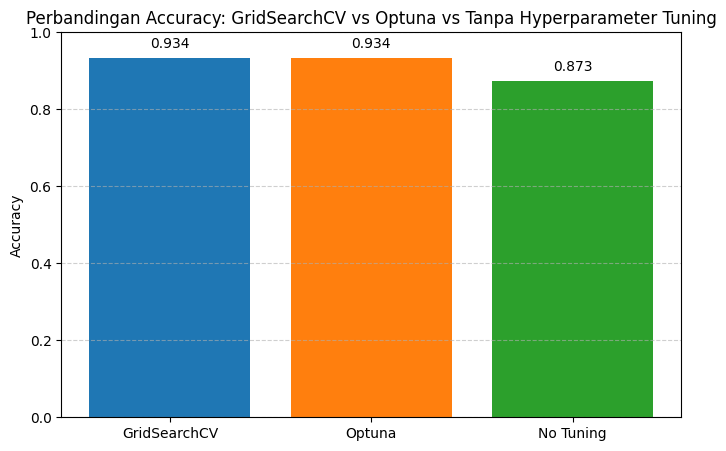

In [49]:
# Plot
acc_series = pd.Series(acc_dict)
acc_series = acc_series.reindex(['GridSearchCV', 'Optuna', 'No Tuning'])  # konsisten urutan

plt.figure(figsize=(8,5))
bars = plt.bar(acc_series.index, acc_series.values, color=['C0','C1','C2'])
plt.ylim(0, 1)
plt.ylabel('Accuracy')
plt.title('Perbandingan Accuracy: GridSearchCV vs Optuna vs Tanpa Hyperparameter Tuning')
plt.grid(axis='y', linestyle='--', alpha=0.6)

# Annotate values
for bar in bars:
    h = bar.get_height()
    plt.annotate(f'{h:.3f}', xy=(bar.get_x() + bar.get_width()/2, h),
                 xytext=(0,5), textcoords='offset points', ha='center', va='bottom')

plt.show()

## Histogram Perbandingan Recall

In [50]:
try:
    rec_dict = {
        'GridSearchCV': rec_grid,
        'Optuna': recall_optuna,
        'No Tuning': recall_raw
    }
except NameError:
    rec_dict = {}
    if 'y_pred_best_grid' in globals():
        rec_dict['GridSearchCV'] = recall_score(y_test, y_pred_best_grid)
    if 'y_pred_optuna' in globals():
        rec_dict['Optuna'] = recall_score(y_test, y_pred_optuna)
    if 'y_pred_raw' in globals():
        rec_dict['No Tuning'] = recall_score(y_test, y_pred_raw)

if not rec_dict:
    raise RuntimeError("Recalls not available. Jalankan cell evaluasi model terlebih dahulu.")

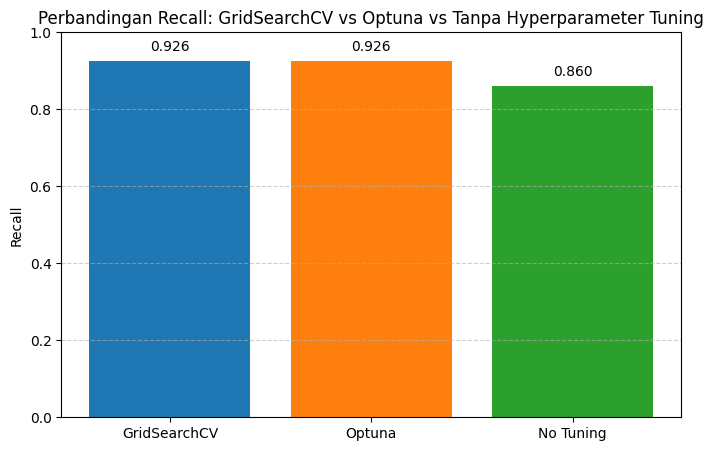

In [51]:
# Plot
rec_series = pd.Series(rec_dict)
rec_series = rec_series.reindex(['GridSearchCV', 'Optuna', 'No Tuning'])  # konsisten urutan

plt.figure(figsize=(8,5))
bars = plt.bar(rec_series.index, rec_series.values, color=['C0','C1','C2'])
plt.ylim(0, 1)
plt.ylabel('Recall')
plt.title('Perbandingan Recall: GridSearchCV vs Optuna vs Tanpa Hyperparameter Tuning')
plt.grid(axis='y', linestyle='--', alpha=0.6)

# Annotate values
for bar in bars:
    h = bar.get_height()
    plt.annotate(f'{h:.3f}', xy=(bar.get_x() + bar.get_width()/2, h),
                 xytext=(0,5), textcoords='offset points', ha='center', va='bottom')

plt.show()

# SAVE ALL

In [52]:
# # Target directory
# os.makedirs('model_deploy', exist_ok=True)
# timestamp = dt.now().strftime('%d%m%Y_%H%M%S')

# # Preprocessing pipeline: MinMaxScaler, PCA, ReshapeTransformer (pkl)
# # path_prep = f'model_deploy/{timestamp}_preprocess.pkl'
# # joblib.dump(preprocess_pipeline, path_prep)
# # print("1. Preprocessing pipeline successfully saved.")

# # Reshaper for input LSTM (pkl)
# path_reshaper = f'model_deploy/{timestamp}_reshaper.pkl'
# joblib.dump(reshape_pipeline, path_reshaper)
# print("1. Reshaper has been successfully saved.")

# # LSTM Model for feature extraction (h5)
# path_lstx = f'model_deploy/{timestamp}_lstmx.h5'
# lstm_last_dense.save(path_lstx)
# print("2. LSTMX pipeline successfully saved.")

# # Hybrid LSTM-XGBoost (json)
# path_hybrid = f'model_deploy/{timestamp}_hybrid_lxgb.json'
# best_hybrid.save_model(path_hybrid)
# print("3. Hybrid model successfully saved.")

<!-- # Contoh cara pake buat prediksi -->

In [53]:
# # --- Load semua komponen ---
# loaded_preprocessor = joblib.load(path_prep)
# loaded_feature_extractor = tf.keras.models.load_model(path_lstx)
# loaded_xgb_model = XGBClassifier()
# loaded_xgb_model.load_model(path_hybrid)


# # --- Buat fungsi prediksi end-to-end ---
# def predict_hybrid_system(data_mentah):
#     """
#     Fungsi ini menjalankan data mentah melalui seluruh alur hybrid.
#     """
#     # Pastikan input adalah 2D
#     if data_mentah.ndim == 1:
#         data_mentah = data_mentah.reshape(1, -1)
        
#     # 1. Jalankan preprocessing
#     data_processed = loaded_preprocessor.transform(data_mentah)
    
#     # 2. Ekstrak fitur dengan LSTM
#     fitur_lstm = loaded_feature_extractor.predict(data_processed)
    
#     # 3. Lakukan prediksi akhir dengan XGBoost
#     prediksi_final = loaded_xgb_model.predict(fitur_lstm)
#     probabilitas = loaded_xgb_model.predict_proba(fitur_lstm)
    
#     return prediksi_final[0], probabilitas[0]


# # --- Uji coba pada satu sampel data mentah ---
# # Ambil satu sampel dari X_test MENTAH (sebelum diproses)
# contoh_data = X_test_mentah[0] 

# hasil, prob = predict_hybrid_system(contoh_data)

# print(f"\n--- Hasil Prediksi pada Data Baru ---")
# print(f"Prediksi Kelas: {hasil} (0=Non-AF, 1=AF)")
# print(f"Probabilitas [Non-AF, AF]: [{prob[0]:.4f}, {prob[1]:.4f}]")